<div style="background: linear-gradient(to right, #4b6cb7, #182848); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: GenAI Results Comparator</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Example: Recipe</p>
</div>
<br>

This notebook demonstrates an example of using the **GAICo (GenAI Results Comparator)** library on the recipe and food domain.

Data is taken from [140,000 English Recipes in computer-readable form with photos and crawl](https://archive.org/details/recipes-en-201706).

Author: Vansh Nagpal

**Scenario:**

1.  **Inputs:** Responses from different models, Mixtral8x7b and Deepseek-R1:8b, corresponding to their attempt at converting a recipe to [R3](https://arxiv.org/abs/2203.17109) format. Since there is no inherent ground-truth, the notebook uses Llama3.1:8b as the ground-truth source.
2.  **Metrics:** We'll use the BLEU, Cosine Similarity, and Levenshtein metrics from the GAICo package.
3.  **Workflow:**
    - Calculate the metric score for the model's response against the reference.
    - Generate a CSV report summarizing the results.
    - Visualize the scores with a bar plot.

**Note:** Since we have a dataset and would like to use the `Experiment` abstraction module, we will create an `Experiment` instance for each data point. After collecting results from each `Experiment` instance, we will aggregate these results to perform an overall analysis of your dataset. Global plotting or CSV generation would then be done on this aggregated data.


## Environment Setup & Imports

The cell below adjusts `sys.path` to find the gaico module if run from examples directory.
This block is primarily for local execution from the `examples/` folder if gaico is not installed.

In Colab however, after pip install, gaico should be importable directly.


In [1]:
# To import `gaico` from the project root, we need to ensure the path is set correctly.
# If this script is run as a standalone file, it will add the project root to the system path.

import sys
import os

notebook_dir = os.getcwd()  # Get the current working directory of the notebook
# Construct the path to the project root (two levels up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from gaico import Experiment
from gaico.visualize import plot_metric_comparison

## Data Reading & Setup

The recipe data is from [140,000 English Recipes in computer-readable form with photos and crawl](https://archive.org/details/recipes-en-201706).

For this notebook's purpose, we read the data file from `GenAIResultsComparator/examples/data/recipes/r3-test-data-gaico.csv`.

In [3]:
data = pd.read_csv(Path("..", "data", "recipes", "r3-test-data-gaico.csv"))
data.head()

,Unnamed: 0,deepseek-r1-8b,llama3.1v2,mixtral8x7b
0,0,"{""recipe_name"":""Quick Kale and Turmeric Smooth...","{""recipe_name"":""Quick Kale and Turmeric Smooth...","{""recipe_name"":""Quick Kale and Turmeric Smooth..."
1,1,"{""recipe_name"":""cheesy-gordita-crunch-copycat""...","{""recipe_name"":""cheesy-gordita-crunch-copycat""...","{""recipe_name"":""Chocolate Chip Cookies"",""macro..."
2,2,"{""recipe_name"":""Poached Salmon with Alfredo Sa...","{""recipe_name"":""Poached Salmon with Alfredo Sa...","{""recipe_name"":""Poached Salmon with Alfredo Sa..."
3,3,"{""recipe_name"":""Beef and Barley Soup I"",""food_...","{""recipe_name"":""Beef and Barley Soup I"",""macro...","{""recipe_name"":""Beef and Barley Soup I"",""macro..."
4,4,"{""recipe"":{""@type"":""Recipe"",""title"":""Apple Cru...","{""recipe_name"":""Apple Crunch Pie with Vanilla ...","""1. Set oven to 400 degrees F (200 degrees C)...."


In [4]:
# Extracting responses for each platform
deepseek_responses = list(data["deepseek-r1-8b"])
llama_responses = list(data["llama3.1v2"])
mixtral_responses = list(data["mixtral8x7b"])

# Extracting the reference responses for comparison
reference_column = list(data["llama3.1v2"])

In [5]:
# Sanity check
assert (
    len(reference_column)
    == len(deepseek_responses)
    == len(llama_responses)
    == len(mixtral_responses)
), "Mismatched response counts"

print(f"Length of the dataset: {len(reference_column)}")
print(f"Combined length: {3 * len(reference_column)}")

Length of the dataset: 1003
Combined length: 3009


## Comparison

Use the `Experiment` sub-module to easily compare all models against the reference answers for the entire dataset.

The new `Experiment` class natively handles batch processing.

In [ ]:
model_refs = {  # Defining the model references for comparison
    "deepseek": deepseek_responses,
    "llama3.1v2": llama_responses,
    "mixtral8x7b": mixtral_responses,
}

In [7]:
# 1. Initialize the Experiment with the entire dataset.
#    The `llm_responses` values are the lists of responses for each model.
exp = Experiment(llm_responses=model_refs, reference_answer=reference_column)

In [8]:
# 2. Run the comparison for the entire batch.
#    The `compare` method will calculate scores for all data points,
#    and can directly output the detailed CSV report.
print("Starting batch comparison...")
final_results_df = exp.compare(
    metrics=["BLEU", "Cosine", "Levenshtein"],
    plot=False,  # We will generate plots manually in the next section
    output_csv_path=Path("..", "data", "recipes", "r3_comparsion.csv"),
)

Starting batch comparison...
CSV report generated at: ../data/recipes/r3_comparsion.csv


In [9]:
print("Metric comparison complete.")
print(final_results_df.head())

Metric comparison complete.
   item_index model_name metric_name     score
0           0   deepseek        BLEU  0.358881
1           0   deepseek      Cosine  0.957099
2           1   deepseek      Cosine  0.597844
3           2   deepseek      Cosine  0.742341
4           3   deepseek      Cosine  0.557741


In [10]:
# Grouping the results by model and metric to calculate mean scores
mean_scores = final_results_df.groupby(["model_name", "metric_name"])["score"].mean().reset_index()
mean_scores = mean_scores.sort_values(by=["model_name", "metric_name"])

print(mean_scores)

    model_name  metric_name     score
0     deepseek         BLEU  0.358881
1     deepseek       Cosine  0.578688
2     deepseek  Levenshtein  0.524184
3   llama3.1v2         BLEU  0.999942
4   llama3.1v2       Cosine  1.000000
5   llama3.1v2  Levenshtein  1.000000
6  mixtral8x7b         BLEU  0.307776
7  mixtral8x7b       Cosine  0.611408
8  mixtral8x7b  Levenshtein  0.553130


## Visualization

Lastly, we plot bar charts for all three different metrics.

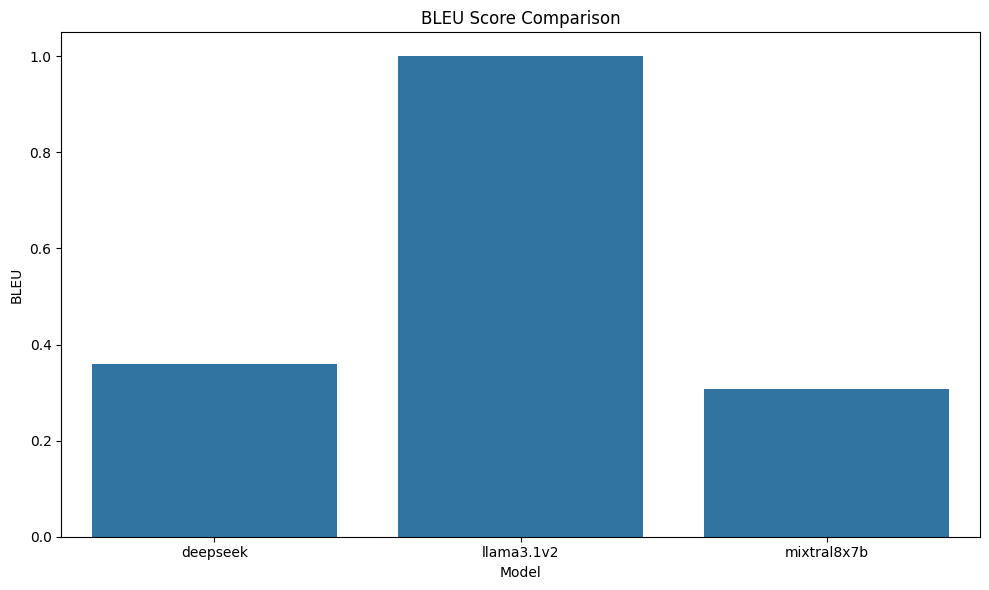

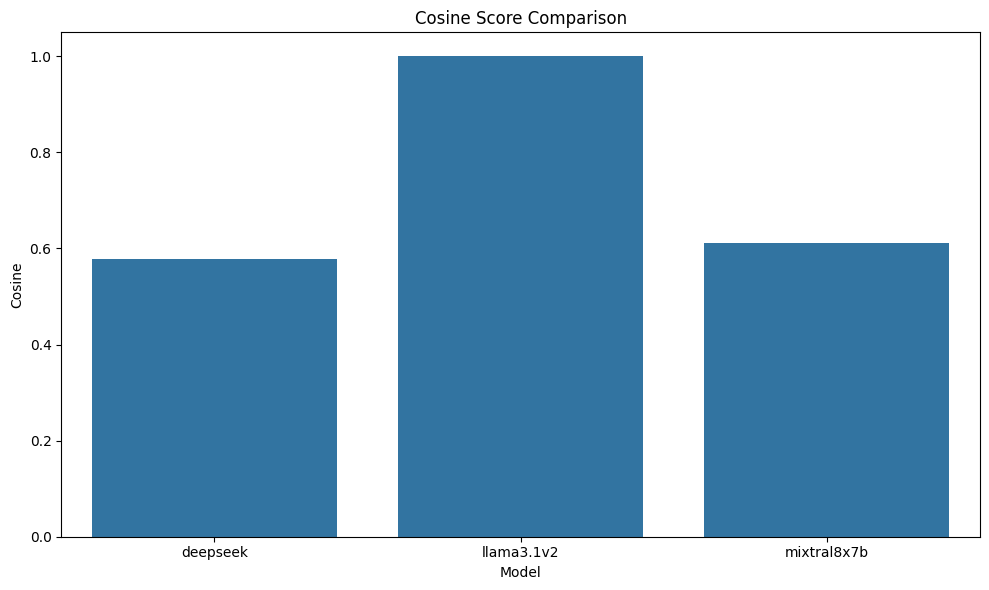

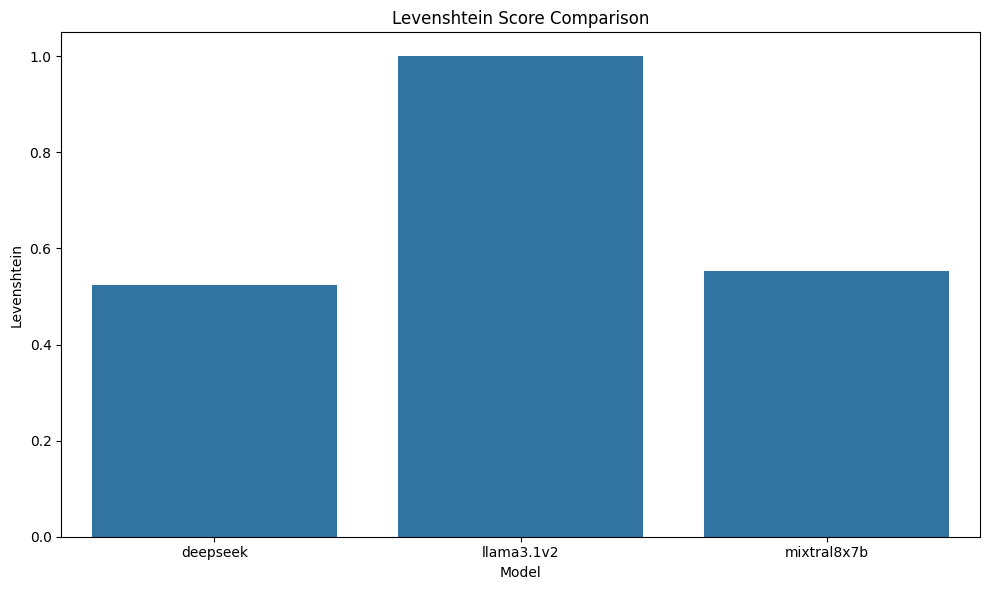

In [11]:
# Plot BLEU scores
plot_metric_comparison(mean_scores, metric_name="BLEU", title="BLEU Score Comparison")
plt.show()

# Plot BLEU scores
plot_metric_comparison(mean_scores, metric_name="Cosine", title="Cosine Score Comparison")
plt.show()

# Plot BLEU scores
plot_metric_comparison(mean_scores, metric_name="Levenshtein", title="Levenshtein Score Comparison")
plt.show()